# Rain Or Crime: Correlations Between Weather and Crime in New York City

In [1]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis and Cleaning

In [2]:
#read csv's into dataframe
weather_data = pd.read_csv('NYC_Weather.csv')
crime_data = pd.read_csv('NYC_Arrests.csv')

In [3]:
weather_data.head()

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WT01,WT02,WT03,WT04,WT05,WT06,WT08
0,USW00094728,"NY CITY CENTRAL PARK, NY US",2015-01-01,7.16,0.00,0.0,0.0,NaN,39,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00094728,"NY CITY CENTRAL PARK, NY US",2015-01-02,7.16,0.00,0.0,0.0,NaN,42,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00094728,"NY CITY CENTRAL PARK, NY US",2015-01-03,6.49,0.71,0.0,0.0,NaN,42,33,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
3,USW00094728,"NY CITY CENTRAL PARK, NY US",2015-01-04,6.49,0.30,0.0,0.0,NaN,56,41,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00094728,"NY CITY CENTRAL PARK, NY US",2015-01-05,10.51,0.00,0.0,0.0,NaN,49,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  3653 non-null   object 
 1   NAME     3653 non-null   object 
 2   DATE     3653 non-null   object 
 3   AWND     3427 non-null   float64
 4   PRCP     3653 non-null   float64
 5   SNOW     3653 non-null   float64
 6   SNWD     3653 non-null   float64
 7   TAVG     0 non-null      float64
 8   TMAX     3653 non-null   int64  
 9   TMIN     3653 non-null   int64  
 10  TSUN     3 non-null      float64
 11  WT01     1410 non-null   float64
 12  WT02     104 non-null    float64
 13  WT03     194 non-null    float64
 14  WT04     11 non-null     float64
 15  WT05     1 non-null      float64
 16  WT06     21 non-null     float64
 17  WT08     688 non-null    float64
dtypes: float64(13), int64(2), object(3)
memory usage: 513.8+ KB


In [5]:
weather_data.describe()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WT01,WT02,WT03,WT04,WT05,WT06,WT08
count,3427.000000,3653.000000,3653.000000,3653.000000,0.0,3653.000000,3653.000000,3.0,1410.0,104.0,194.0,11.0,1.0,21.0,688.0
mean,5.032822,0.137914,0.067725,0.274569,NaN,63.926088,49.839036,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,2.368061,0.376324,0.721483,1.535005,NaN,17.715857,16.389005,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,NaN,13.000000,-1.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,3.360000,0.000000,0.000000,0.000000,NaN,49.000000,37.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,4.700000,0.000000,0.000000,0.000000,NaN,65.000000,50.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,6.260000,0.060000,0.000000,0.000000,NaN,79.000000,65.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,18.340000,7.130000,27.300000,22.000000,NaN,98.000000,82.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


We can see that there are many null values in the dataframe. To fix this, we can drop columns where there are mainly null values, such as TAVG and TSUN, which are the average temperature and toal sunshine. For the AWND column, which is the average wind speed, most of the values are not null. In this case, we can use imputation and fill the null values with the average of the rest of the column.

The columns beginning with WT are either 1 or null. They correspond to a binary variable indicating whether a certain weather condition is present or not, so the null values can be interpreted as 0. For example, if WT01 has a value of 1, that indicates fog. This info can be found at the documentation: https://www.ncei.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf.

In [6]:
#drop TAVG and TSUN columns
weather_data = weather_data.drop(columns=['TAVG', 'TSUN'])

#impute AWND column with mean
weather_data['AWND'] = weather_data['AWND'].fillna(weather_data['AWND'].mean())

#fill WT columns null values with 0
wt_columns = [col for col in weather_data.columns if col.startswith('WT')]
for col in wt_columns:
    weather_data[col] = weather_data[col].fillna(0)

From the documentation, we can also reduce some of our features. We are told that WT01 and WT02 are not always distinguished from each other (they may indicate the same thing) and the same goes for WT04 and WT05. We can combine these columns.

In [7]:
#combine WT01 and WT02, WT04 and WT05
weather_data['WT01_02'] = weather_data[['WT01', 'WT02']].max(axis=1)
weather_data['WT04_05'] = weather_data[['WT04', 'WT05']].max(axis=1)
weather_data = weather_data.drop(columns=['WT01', 'WT02', 'WT04', 'WT05'])

Now we can clean up the crime data and attach the weather data to it.

In [8]:
crime_data.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,298702124,12/31/2024,511.0,"CONTROLLED SUBSTANCE, POSSESSI",235.0,DANGEROUS DRUGS,PL 2200300,M,K,81,0,25-44,M,BLACK,1002822.0,189890.0,40.687872,-73.933032,POINT (-73.933032 40.687872)
1,298699274,12/31/2024,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200502,F,M,32,0,25-44,F,BLACK,998348.0,235496.0,40.813056,-73.949068,POINT (-73.949068 40.813056)
2,298679856,12/31/2024,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200512,F,B,40,1,25-44,F,WHITE HISPANIC,1007046.0,236603.0,40.816067,-73.917644,POINT (-73.91764392674679 40.81606683945181)
3,298694773,12/31/2024,268.0,CRIMINAL MIS 2 & 3,121.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450502,F,B,42,0,25-44,M,BLACK,1010240.0,238959.0,40.822534,-73.906096,POINT (-73.906096 40.822534)
4,298703584,12/31/2024,259.0,"CRIMINAL MISCHIEF,UNCLASSIFIED 4",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450001,M,M,14,0,25-44,M,WHITE HISPANIC,987044.0,213239.0,40.751978,-73.989915,POINT (-73.989915 40.751978)


In [9]:

crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2374606 entries, 0 to 2374605
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ARREST_KEY         int64  
 1   ARREST_DATE        object 
 2   PD_CD              float64
 3   PD_DESC            object 
 4   KY_CD              float64
 5   OFNS_DESC          object 
 6   LAW_CODE           object 
 7   LAW_CAT_CD         object 
 8   ARREST_BORO        object 
 9   ARREST_PRECINCT    int64  
 10  JURISDICTION_CODE  int64  
 11  AGE_GROUP          object 
 12  PERP_SEX           object 
 13  PERP_RACE          object 
 14  X_COORD_CD         float64
 15  Y_COORD_CD         float64
 16  Latitude           float64
 17  Longitude          float64
 18  Lon_Lat            object 
dtypes: float64(6), int64(3), object(10)
memory usage: 344.2+ MB


In [10]:
crime_data.describe()

,ARREST_KEY,PD_CD,KY_CD,ARREST_PRECINCT,JURISDICTION_CODE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
count,2.374606e+06,2.373873e+06,2.370056e+06,2.374606e+06,2.374606e+06,2.374606e+06,2.374606e+06,2.374602e+06,2.374602e+06
mean,2.032738e+08,4.562853e+02,2.677874e+02,6.208587e+01,1.366171e+00,1.005287e+06,2.083437e+05,4.073830e+01,-7.392370e+01
std,5.006066e+07,2.749846e+02,1.559954e+02,3.484200e+01,9.787931e+00,2.119593e+04,2.969976e+04,1.197188e-01,1.763432e-01
min,1.403945e+08,0.000000e+00,1.010000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.425494e+01
25%,1.576361e+08,2.030000e+02,1.170000e+02,3.400000e+01,0.000000e+00,9.912210e+05,1.860690e+05,4.067732e+01,-7.397487e+01
50%,1.917320e+08,4.390000e+02,3.410000e+02,6.100000e+01,0.000000e+00,1.004749e+06,2.073960e+05,4.073585e+01,-7.392593e+01
75%,2.465216e+08,7.290000e+02,3.440000e+02,9.400000e+01,0.000000e+00,1.017119e+06,2.358890e+05,4.081412e+01,-7.388151e+01
max,2.987485e+08,9.970000e+02,9.950000e+02,4.830000e+02,9.700000e+01,1.067302e+06,2.719090e+05,4.091296e+01,0.000000e+00


In [11]:
crime_data.isna().sum()

ARREST_KEY               0
ARREST_DATE              0
PD_CD                  733
PD_DESC               3931
KY_CD                 4550
OFNS_DESC             3931
LAW_CODE                45
LAW_CAT_CD           14983
ARREST_BORO              0
ARREST_PRECINCT          0
JURISDICTION_CODE        0
AGE_GROUP                0
PERP_SEX                 0
PERP_RACE                0
X_COORD_CD               0
Y_COORD_CD               0
Latitude                 4
Longitude                4
Lon_Lat                  4
dtype: int64

In [12]:
crime_data['LAW_CAT_CD'].value_counts(dropna=False)

LAW_CAT_CD
M         1425032
F          873800
V           52256
NaN         14983
I            6724
9            1801
(null)         10
Name: count, dtype: int64

First, we can drop all columns with location data, as our analysis assumes the weather in NYC is fairly consistent and we do not need to zoom in to individual boroughs or precicnts. We will eventually try to predict the the LAW_CAT_CD column, which tells us the level of offense: felony (F), misdemeansor (M), or violation (V). We will drop rows where the LAW_CAT_CD column does not match these values. We can edit the date format to match the weather data date format. Finally, we can do a one-hot encoding on the PERP_RACE, PERP_SEX, and AGE_GROUP variables. Documenation for this dataset is at https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u/about_data.

In [13]:
import datetime as dt

#drop rows with LAW_CAT_CD not in F, M, V
crime_data = crime_data[crime_data['LAW_CAT_CD'].isin(['F', 'M', 'V'])]

#drop location data columns
crime_data = crime_data.drop(columns=['JURISDICTION_CODE', 'ARREST_PRECINCT', 'ARREST_BORO', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lon_Lat'])

#one-hot encode PERP_SEX column
crime_data = pd.get_dummies(crime_data, columns=['PERP_SEX'])

#one-hot encode PERP_RACE column
crime_data = pd.get_dummies(crime_data, columns=['PERP_RACE'])

#one-hot encode AGE_GROUP column
crime_data = pd.get_dummies(crime_data, columns=['AGE_GROUP'])

#edit date format to match weather data
crime_data['ARREST_DATE'] = pd.to_datetime(crime_data['ARREST_DATE']).dt.strftime('%Y-%m-%d')

In [14]:
crime_data

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,PERP_SEX_F,PERP_SEX_M,...,PERP_RACE_BLACK,PERP_RACE_BLACK HISPANIC,PERP_RACE_UNKNOWN,PERP_RACE_WHITE,PERP_RACE_WHITE HISPANIC,AGE_GROUP_18-24,AGE_GROUP_25-44,AGE_GROUP_45-64,AGE_GROUP_65+,AGE_GROUP_<18
0,298702124,2024-12-31,511.0,"CONTROLLED SUBSTANCE, POSSESSI",235.0,DANGEROUS DRUGS,PL 2200300,M,False,True,...,True,False,False,False,False,False,True,False,False,False
1,298699274,2024-12-31,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200502,F,True,False,...,True,False,False,False,False,False,True,False,False,False
2,298679856,2024-12-31,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200512,F,True,False,...,False,False,False,False,True,False,True,False,False,False
3,298694773,2024-12-31,268.0,CRIMINAL MIS 2 & 3,121.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450502,F,False,True,...,True,False,False,False,False,False,True,False,False,False
4,298703584,2024-12-31,259.0,"CRIMINAL MISCHIEF,UNCLASSIFIED 4",351.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450001,M,False,True,...,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374601,140400881,2015-01-02,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,False,True,...,False,False,False,False,True,False,True,False,False,False
2374602,140400779,2015-01-02,849.0,"NY STATE LAWS,UNCLASSIFIED VIOLATION",677.0,OTHER STATE LAWS,LOC000000V,V,False,True,...,True,False,False,False,False,False,False,True,False,False
2374603,140400855,2015-01-02,339.0,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",341.0,PETIT LARCENY,PL 1552500,M,False,True,...,False,False,False,True,False,False,True,False,False,False
2374604,140400888,2015-01-02,503.0,"CONTROLLED SUBSTANCE,INTENT TO SELL 3",117.0,DANGEROUS DRUGS,PL 2201601,F,False,True,...,False,False,False,True,False,False,False,True,False,False


Now we can merge the dataset by the dates. Since multiple arrests are made on the same day, we will repeat the weather data for the day for each arrest.

In [15]:
#merge crime and weather data by date
data = pd.merge(crime_data, weather_data, left_on='ARREST_DATE', right_on='DATE', how='left')

In [16]:
data.columns

Index(['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC',
       'LAW_CODE', 'LAW_CAT_CD', 'PERP_SEX_F', 'PERP_SEX_M', 'PERP_SEX_U',
       'PERP_RACE_AMERICAN INDIAN/ALASKAN NATIVE',
       'PERP_RACE_ASIAN / PACIFIC ISLANDER', 'PERP_RACE_BLACK',
       'PERP_RACE_BLACK HISPANIC', 'PERP_RACE_UNKNOWN', 'PERP_RACE_WHITE',
       'PERP_RACE_WHITE HISPANIC', 'AGE_GROUP_18-24', 'AGE_GROUP_25-44',
       'AGE_GROUP_45-64', 'AGE_GROUP_65+', 'AGE_GROUP_<18', 'STATION', 'NAME',
       'DATE', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'WT03', 'WT06',
       'WT08', 'WT01_02', 'WT04_05'],
      dtype='object')

## Daily Arrest Predictions

We can start by using the weather to predict daily statistics of crime, such as number of arrests. We start by doing feature engineering.

In [18]:
#dataframe for daily crime statistics
daily_data = data.groupby('ARREST_DATE').agg(
    NUM_ARRESTS = ('ARREST_KEY', 'count')
).reset_index().merge(weather_data, left_on='ARREST_DATE', right_on='DATE', how='left')

In [19]:
daily_data.columns

Index(['ARREST_DATE', 'NUM_ARRESTS', 'STATION', 'NAME', 'DATE', 'AWND', 'PRCP',
       'SNOW', 'SNWD', 'TMAX', 'TMIN', 'WT03', 'WT06', 'WT08', 'WT01_02',
       'WT04_05'],
      dtype='object')

We can take an 80/20 train/test split on our data, then train a Random Forest Regressor model on the data. This model is a good choice because it handles interactions between features well, as well as nonlinear relationships between features. We will train 3 different versions of the model with different hyperparameters and compare their performance.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    daily_data.drop(columns=['ARREST_DATE', 'DATE', 'STATION', 'NAME', 'NUM_ARRESTS']),
    daily_data['NUM_ARRESTS'],
    test_size=0.2,
    random_state=42
)

In [22]:
#Low bias, could have high variance and overfit
forestOne = RandomForestRegressor(
    n_estimators=800,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="log2",
    bootstrap=True
)

forestOne.fit(X_train, y_train)

,n_estimators,800
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
#ForestOne model performance
y_pred = forestOne.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for NUM_ARRESTS: {mse}")

Mean Squared Error for NUM_ARRESTS: 54121.27034896113


In [24]:
#More regularized model, could have high bias
forestTwo = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features=0.5,
    bootstrap=True
)

forestTwo.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
#ForestTwo model performance
y_pred = forestTwo.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for NUM_ARRESTS: {mse}")

Mean Squared Error for NUM_ARRESTS: 49891.61491715063


In [26]:
#Midpoint between previous two models
forestThree = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True
)

forestThree.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
#ForestThree model performance
y_pred = forestThree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for NUM_ARRESTS: {mse}")

Mean Squared Error for NUM_ARRESTS: 54337.01278026279


The best model is ForestTwo, the regularized model. We can do further tests on this model's performance.

In [28]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#ForestTwo additional performance metrics
y_pred = forestTwo.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error for NUM_ARRESTS: {mae}")
print(f"R^2 Score for NUM_ARRESTS: {r2}")

Mean Absolute Error for NUM_ARRESTS: 178.7068202817939
R^2 Score for NUM_ARRESTS: 0.02407395609993268


For even our best model, the $R^2$ score is close to 0. This means our model does not have much predicting power. We should do K-fold cross validation to ensure that this is not because of an unlucky train/test split.

In [29]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(forestTwo, daily_data.drop(columns=['ARREST_DATE', 'DATE', 'STATION', 'NAME', 'NUM_ARRESTS']), daily_data['NUM_ARRESTS'], cv=kf, scoring='r2')

print(f"Cross-validated R^2 scores: {r2_scores}")

Cross-validated R^2 scores: [0.02587019 0.01719638 0.02110177 0.04397325 0.03964907]


For each fold, we see that the $R^2$ is still close to 0. We can also plot the predicted values against the actual results below.

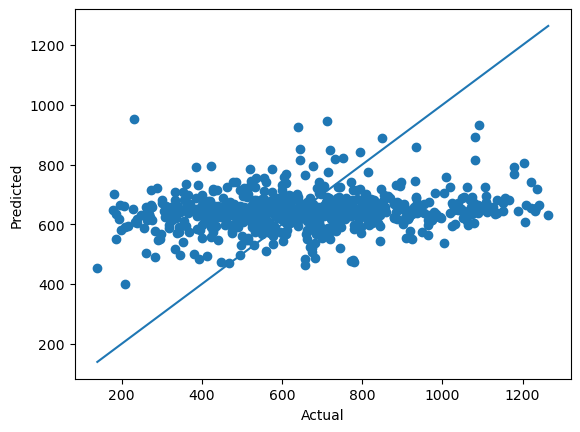

In [30]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

All these results indicate that the weather is not a good predictor of the amount of criminal activity in NYC. Let's also see the feature importance to guide the next step in the analysis.

In [31]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(forestTwo, X_test, y_test, n_repeats=10, random_state=42)

importances = perm.importances_mean
feat_imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance": importances
}).sort_values("importance", ascending=False)
print(feat_imp)

    feature  importance
1      PRCP    0.034809
6      WT03    0.021752
4      TMAX    0.018231
8      WT08    0.015331
3      SNWD    0.012426
0      AWND    0.004141
2      SNOW    0.003532
9   WT01_02    0.002940
7      WT06    0.000023
10  WT04_05    0.000000
5      TMIN   -0.008949


We used permutation importance to calculate feature importance. This shuffles features one by one and determines the model's performance after that feature has been shuffled. This method is better than the default feature importance calculation because it does not give unfair importance to continuous variables. If the importance value is positive, it shows that the model performance dropped when that feature was shuffled. Negative values indicate that the model performance got better, meaning that feature is not helpful for prediction.

## Crime Severity Prediction

Now we can use the weather variables, as well as all the other crime variables, to predict the severity of a crime: Felony, Misdemeanor, or Violation.  We can drop the weather variables that were determined to be useless by the previous feature importance analysis. We will also use L1 (lasso) regularization, in case our model determines that the weather variables are unnecessary and should be eliminated.

In [32]:
#make train/test split with the data for the logistic regression model
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['ARREST_KEY', 'ARREST_DATE', 'DATE', 'STATION', 'NAME', 'LAW_CAT_CD', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'WT01_02', 'WT06', 'WT04_05', 'TMIN']),
    data['LAW_CAT_CD'],
    test_size=0.2,
    random_state=42
)

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


#scaling is important for logistic regression, but not for one-hot encoded variables
numericFeatures = ['AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'WT03']
oneHotFeatures = [col for col in X_train.columns if col not in numericFeatures]

transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericFeatures),
        ('cat', 'passthrough', oneHotFeatures)
    ]
)

X_train_scaled = transformer.fit_transform(X_train)
X_test_scaled = transformer.transform(X_test)

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

#create the transofmation and regression pipeline
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('logreg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000))
])

In order to find the optimal hyperparamaters for the model, we will use GridSearchCV. This uses k-fold cross validation while varying hyper parameters of our model to find the optimal configuration.

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100], #inverse of regularization strength
    'logreg__penalty': ['l1'],  # use l1 regularization to eliminate useless features
    'logreg__solver': ['saga']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/darshan/anaconda3/envs/weathercrime/lib/py

[CV] END logreg__C=0.01, logreg__penalty=l1, logreg__solver=saga; total time=13.2min
[CV] END logreg__C=0.01, logreg__penalty=l1, logreg__solver=saga; total time=13.3min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END logreg__C=0.01, logreg__penalty=l1, logreg__solver=saga; total time=13.6min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END logreg__C=0.01, logreg__penalty=l1, logreg__solver=saga; total time=14.0min
[CV] END logreg__C=0.01, logreg__penalty=l1, logreg__solver=saga; total time=14.1min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=saga; total time=54.3min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=saga; total time=54.7min
[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=saga; total time=54.9min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=saga; total time=51.2min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=saga; total time=52.1min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=saga; total time=17.2min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=saga; total time=16.1min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=saga; total time=16.6min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=saga; total time=16.5min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=saga; total time=82.8min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=saga; total time=82.8min
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=saga; total time=82.7min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=saga; total time=16.6min
[CV] END logreg__C=100, logreg__penalty=l1, logreg__solver=saga; total time=18.0min
[CV] END logreg__C=100, logreg__penalty=l1, logreg__solver=saga; total time=15.4min
[CV] END logreg__C=100, logreg__penalty=l1, logreg__solver=saga; total time=12.3min
[CV] END logreg__C=100, logreg__penalty=l1, logreg__solver=saga; total time=12.1min
[CV] END logreg__C=100, logreg__penalty=l1, logreg__solver=saga; total time=12.2min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=saga; total time=60.4min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=saga; total time=60.1min


/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'logreg__C': 0.01, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best cross-validation accuracy: 0.6106695305895676


In [51]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

              precision    recall  f1-score   support

           F       0.57      0.04      0.08    174962
           M       0.61      0.98      0.75    284882
           V       0.00      0.00      0.00     10374

    accuracy                           0.61    470218
   macro avg       0.39      0.34      0.28    470218
weighted avg       0.58      0.61      0.49    470218

[[  7756 167206      0]
 [  5802 279080      0]
 [   108  10266      0]]


In [ ]:
import joblib
#save the model
joblib.dump(grid_search, "gridsearch_full.pkl")

['gridsearch_full.pkl']

We can see above that the model performed poorly, probably because of the severe class imbalance (many more misdemeanors than felonies or violations). To fix this, we can tell our model to use weighting on the classes and use the same hyperparameters from before to train a better model.

In [53]:
#create the transofmation and regression pipeline
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('logreg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, class_weight='balanced', penalty='l1', C=0.01))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

/Users/darshan/anaconda3/envs/weathercrime/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           F       0.43      0.29      0.35    174962
           M       0.65      0.31      0.42    284882
           V       0.03      0.65      0.06     10374

    accuracy                           0.31    470218
   macro avg       0.37      0.42      0.27    470218
weighted avg       0.55      0.31      0.38    470218

[[ 51450  44949  78563]
 [ 66581  87104 131197]
 [  1840   1836   6698]]


In [54]:
importance = permutation_importance(
    pipeline,
    X_test,
    y_test,
    n_repeats=10,
    scoring='f1_macro',
    random_state=42
)

importancesMean = importance.importances_mean
importancesStd = importance.importances_std


featureNames = (
    numericFeatures +
    oneHotFeatures 
)


perm_importance_df = pd.DataFrame({
    'feature': featureNames,
    'importance_mean': importancesMean,
    'importance_std': importancesStd
}).sort_values(by='importance_mean', ascending=False)

print(perm_importance_df)


                                     feature  importance_mean  importance_std
1                                       PRCP         0.006970        0.000371
5                                       WT03         0.006361        0.000239
14                           PERP_RACE_WHITE         0.005088        0.000173
20                             AGE_GROUP_<18         0.004967        0.000134
21                                      WT08         0.002639        0.000211
8                                 PERP_SEX_U         0.000577        0.000145
4                                       TMAX         0.000514        0.000154
12                  PERP_RACE_BLACK HISPANIC         0.000507        0.000246
6                                 PERP_SEX_F         0.000458        0.000246
3                                       SNWD         0.000143        0.000028
13                         PERP_RACE_UNKNOWN         0.000140        0.000049
11                           PERP_RACE_BLACK         0.000000   

Based on the performance report of the model as well as the feature importance analysis, we can see that the model has not learned anything from the variables. Before we conclude that these variables are not good predictors of the severity of a crime, let's try a Random Forest Classifier model and use the Grid Search CV to find its optimal parameters.

In [56]:
#use random forest classifier instead of logistic regression
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('forest', forest)
])

param_grid = {
    'forest__n_estimators': [200, 400],
    'forest__max_depth': [10, 20, None],
    'forest__min_samples_split': [10],
    'forest__min_samples_leaf': [10],
    'forest__max_features': ['sqrt']
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,                      
    scoring='f1_macro',        
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END forest__max_depth=10, forest__max_features=sqrt, forest__min_samples_leaf=10, forest__min_samples_split=10, forest__n_estimators=200; total time= 8.5min
[CV] END forest__max_depth=10, forest__max_features=sqrt, forest__min_samples_leaf=10, forest__min_samples_split=10, forest__n_estimators=200; total time= 8.6min
[CV] END forest__max_depth=10, forest__max_features=sqrt, forest__min_samples_leaf=10, forest__min_samples_split=10, forest__n_estimators=200; total time= 8.6min
[CV] END forest__max_depth=20, forest__max_features=sqrt, forest__min_samples_leaf=10, forest__min_samples_split=10, forest__n_estimators=200; total time=12.2min
[CV] END forest__max_depth=20, forest__max_features=sqrt, forest__min_samples_leaf=10, forest__min_samples_split=10, forest__n_estimators=200; total time=12.3min
[CV] END forest__max_depth=10, forest__max_features=sqrt, forest__min_samples_leaf=10, forest__min_samples_split=10, forest__n_est

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'forest__max_depth': [10, 20, ...], 'forest__max_features': ['sqrt'], 'forest__min_samples_leaf': [10], 'forest__min_samples_split': [10], ...}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [58]:
joblib.dump(grid, "forestGrid_full.pkl")

['forestGrid_full.pkl']

In [ ]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("Best parameters:", grid.best_params_)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best parameters: {'forest__max_depth': None, 'forest__max_features': 'sqrt', 'forest__min_samples_leaf': 10, 'forest__min_samples_split': 10, 'forest__n_estimators': 400}
              precision    recall  f1-score   support

           F       0.45      0.48      0.46    174962
           M       0.66      0.41      0.51    284882
           V       0.06      0.59      0.10     10374

    accuracy                           0.44    470218
   macro avg       0.39      0.49      0.36    470218
weighted avg       0.57      0.44      0.48    470218

[[ 83384  57159  34419]
 [ 99156 116860  68866]
 [  1642   2578   6154]]


In [61]:
importance = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    scoring='f1_macro',
    random_state=42
)

importancesMean = importance.importances_mean
importancesStd = importance.importances_std


featureNames = (
    numericFeatures +
    oneHotFeatures 
)


perm_importance_df = pd.DataFrame({
    'feature': featureNames,
    'importance_mean': importancesMean,
    'importance_std': importancesStd
}).sort_values(by='importance_mean', ascending=False)

print(perm_importance_df)


                                     feature  importance_mean  importance_std
19                             AGE_GROUP_65+     1.435213e-02        0.000456
15                  PERP_RACE_WHITE HISPANIC     1.253539e-02        0.000461
21                                      WT08     4.894555e-03        0.000258
14                           PERP_RACE_WHITE     3.384095e-03        0.000080
18                           AGE_GROUP_45-64     2.178840e-03        0.000146
16                           AGE_GROUP_18-24     1.799904e-03        0.000317
20                             AGE_GROUP_<18     1.279909e-03        0.000144
13                         PERP_RACE_UNKNOWN     1.933615e-05        0.000041
2                                       SNOW    -4.692811e-07        0.000011
3                                       SNWD    -2.228516e-05        0.000014
7                                 PERP_SEX_M    -2.667543e-04        0.000023
17                           AGE_GROUP_25-44    -7.048625e-04   

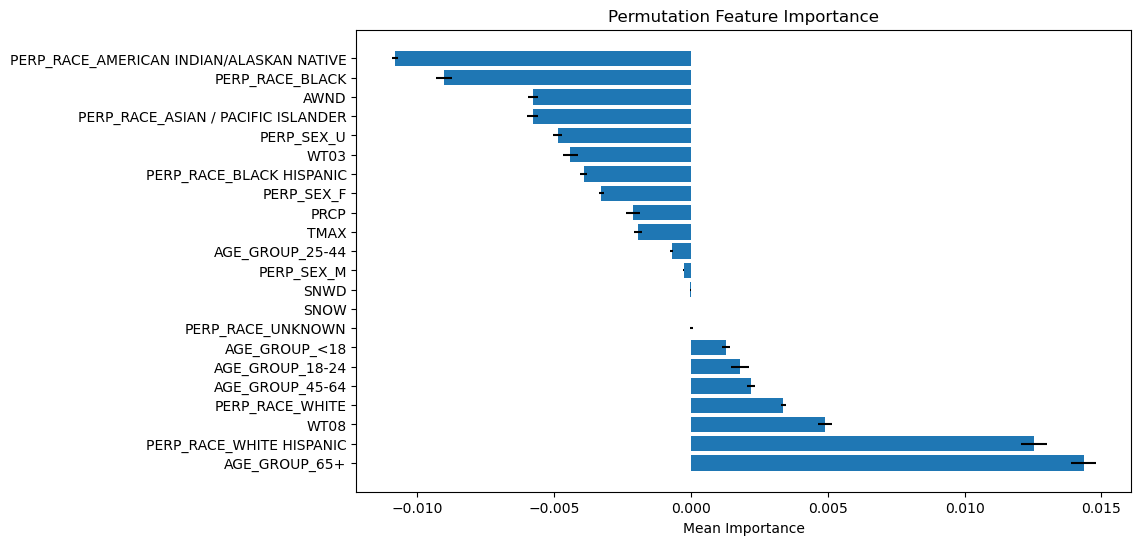

In [62]:
#plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(perm_importance_df['feature'], perm_importance_df['importance_mean'], xerr=perm_importance_df['importance_std'])
plt.xlabel('Mean Importance')
plt.title('Permutation Feature Importance')
plt.show()

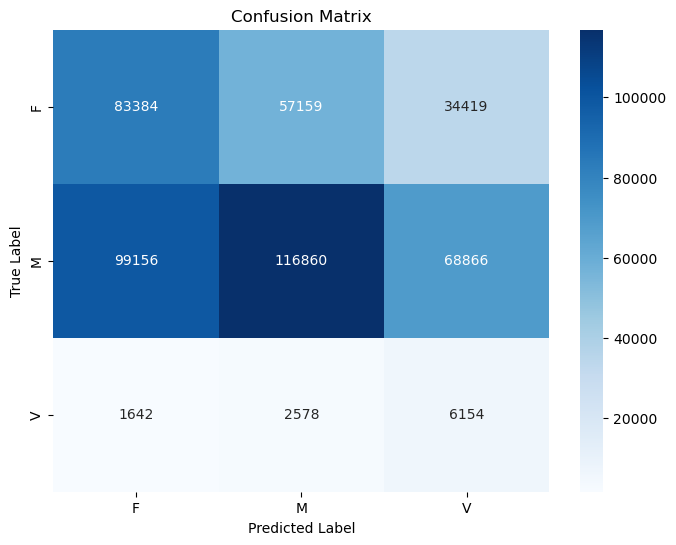

In [66]:
#plot confusion matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Although the performance report for the model was better, it still indicates that our model is not able to predict the severity of crime very well. Interestingly, one of our weather indicators made it into the top 3 features, WT08. This is the indicator that there was smoke or haze that day. Still, due to our weak model and the low importance values for each feature, it is unlikely that any of our weather variables are effective in predicting criminal activity in NYC.